In [1]:
from PIL import Image
import bayes3d as b
import os
import numpy as np
import jax.numpy as jnp
from tqdm import tqdm
import jax
import trimesh

In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7044/static/


In [3]:
f = open(os.path.join(b.utils.get_assets_dir(), f"tum/livingRoom1.gt.freiburg"),"r")
data = f.readlines()
data = [d.strip('\n') for d in data]
poses = [jnp.eye(4)]

xyzw_to_rotation_matrix = jax.jit(b.t3d.xyzw_to_rotation_matrix)
transform_from_rot_and_pos = jax.jit(b.t3d.transform_from_rot_and_pos)
for i in tqdm(range(len(data))):
    xyzq = list(map(float,data[i].split(" ")))[1:]
    pos = jnp.array([xyzq[:3]])
    rot = b.xyzw_to_rotation_matrix(jnp.array(xyzq[3:]))
    pose = transform_from_rot_and_pos(rot, pos)
    poses.append(pose)
poses = jnp.array(poses)

100%|██████████| 965/965 [00:12<00:00, 75.53it/s]


In [4]:
IDX = 0
rgbs = []
original_depths = []
for IDX in tqdm(range(len(poses))):
    depth_filename = os.path.join(b.utils.get_assets_dir(), f"tum/depth/{IDX}.png")
    rgb_filename = os.path.join(b.utils.get_assets_dir(), f"tum/rgb/{IDX}.png")
    rgbs.append(jnp.array(Image.open(rgb_filename)))
    original_depths.append(np.array(Image.open(depth_filename)) / 5000)

100%|██████████| 966/966 [00:16<00:00, 58.43it/s]


In [5]:
original_intrinsics = b.Intrinsics(
    original_depths[0].shape[0], original_depths[1].shape[1],
    481.20, 480.00,319.50,239.50,0.001, 6.0
)
intrinsics = b.camera.scale_camera_parameters(original_intrinsics, 0.2)
depths = [b.utils.resize(d, intrinsics.height, intrinsics.width) for d in original_depths]

In [6]:
from bayes3d.rendering.nvdiffrast_jax.jax_renderer import Renderer as JaxRenderer
jax_renderer = JaxRenderer(intrinsics)

In [7]:
b.clear()
point_cloud_first = b.unproject_depth_jit(depths[0], intrinsics)
b.show_cloud("1", point_cloud_first.reshape(-1,3))

In [9]:
def point_cloud_image_to_trimesh(point_cloud_image):
    height, width, _ = point_cloud_image.shape
    ij_to_index = lambda i,j: i * width + j
    ij_to_faces = lambda ij: jnp.array(
        [
            [ij_to_index(ij[0], ij[1]), ij_to_index(ij[0]+1, ij[1]), ij_to_index(ij[0], ij[1]+1)],
            [ij_to_index(ij[0]+1, ij[1]), ij_to_index(ij[0]+1, ij[1]+1), ij_to_index(ij[0], ij[1]+1)]
        ]
    )
    jj, ii = jnp.meshgrid(jnp.arange(width-1), jnp.arange(height-1))
    indices = jnp.stack([ii,jj],axis=-1)
    faces = jax.vmap(ij_to_faces)(indices.reshape(-1,2)).reshape(-1,3)
    print(faces.shape)
    vertices = point_cloud_image.reshape(-1,3)
    mesh = trimesh.Trimesh(vertices, faces)
    return mesh

In [11]:
mesh = point_cloud_image_to_trimesh(point_cloud_first)
b.show_trimesh("mesh", mesh) 
vertices,faces = jnp.array(mesh.vertices), jnp.array(mesh.faces)

(24130, 3)


In [110]:
def render_image_from_pose(trans,q):
    camera_pose = b.translation_and_quaternion_to_pose_matrix(trans, q)
    img = jax_renderer.render(vertices, faces, b.inverse_pose(camera_pose), intrinsics)[0][0,...]
    return img

def loss_func(trans, q, obs_depth):
    img = render_image_from_pose(trans,q)
    diffs = jnp.abs(img - obs_depth)
    return (diffs * (img > 0.001)).mean()
    # return jnp.abs(img - obs_depth).mean()
    

value_and_grad_jit = jax.jit(jax.value_and_grad(loss_func, argnums=(0,1,)))

(24130, 3)
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
(96, 128)
2.2798001e-09


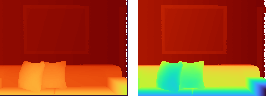

In [116]:
tr,q = jnp.zeros(3), jnp.array([1.0, 0.0, 0.0, 0.0])

timestep = 0

mesh = point_cloud_image_to_trimesh(b.apply_transform(b.unproject_depth_jit(depths[timestep], intrinsics), b.translation_and_quaternion_to_pose_matrix(tr,q)))
b.clear()
b.show_pose("inferred", b.translation_and_quaternion_to_pose_matrix(tr,q), size=0.1)
b.show_trimesh("mesh", mesh) 
vertices,faces = jnp.array(mesh.vertices), jnp.array(mesh.faces)

print(b.translation_and_quaternion_to_pose_matrix(tr,q))
img = render_image_from_pose(tr,q)
print(img.shape)
print(loss_func(tr,q, depths[0]))

b.hstack_images([b.get_depth_image(img), b.get_depth_image(depths[0])])

In [123]:
pbar = tqdm(range(200))
timestep = 100
for _  in pbar:
    loss, (g1, g2) = value_and_grad_jit(tr, q, depths[timestep])
    tr -= g1 * 0.001
    q -= g2 * 0.001
    pbar.set_description(f"{loss}")
b.show_pose("inferred", b.translation_and_quaternion_to_pose_matrix(tr,q), size=0.1)

0.0018457567784935236: 100%|██████████| 200/200 [00:00<00:00, 379.97it/s]


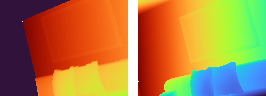

In [125]:
rendered_img = render_image_from_pose(tr,q)
b.clear()
b.show_cloud("cloud", b.unproject_depth_jit(rendered_img, intrinsics).reshape(-1,3))
b.show_cloud("cloud2", b.unproject_depth_jit(depths[timestep], intrinsics).reshape(-1,3),color=b.RED)
b.hstack_images(
    [
        b.get_depth_image(rendered_img),
        b.get_depth_image(depths[timestep])
    ]
)

In [98]:
mesh = point_cloud_image_to_trimesh(b.apply_transform(b.unproject_depth_jit(depths[timestep], intrinsics), b.translation_and_quaternion_to_pose_matrix(tr,q)))
b.clear()
b.show_pose("inferred", b.translation_and_quaternion_to_pose_matrix(tr,q), size=0.1)
b.show_trimesh("mesh", mesh) 
vertices,faces = jnp.array(mesh.vertices), jnp.array(mesh.faces)

(24130, 3)


[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
(96, 128)


Array([[ 2.001,  2.001,  2.002, ...,  2.058,  2.059, -0.   ],
       [ 2.001,  2.001,  2.002, ...,  2.058,  2.058, -0.   ],
       [ 2.001,  2.001,  2.001, ...,  2.058,  2.059, -0.   ],
       ...,
       [ 1.389,  1.39 ,  1.389, ...,  1.178,  1.16 , -0.   ],
       [ 1.36 ,  1.36 ,  1.36 , ...,  1.178,  1.16 , -0.   ],
       [-0.   , -0.   , -0.   , ..., -0.   , -0.   , -0.   ]],      dtype=float32)

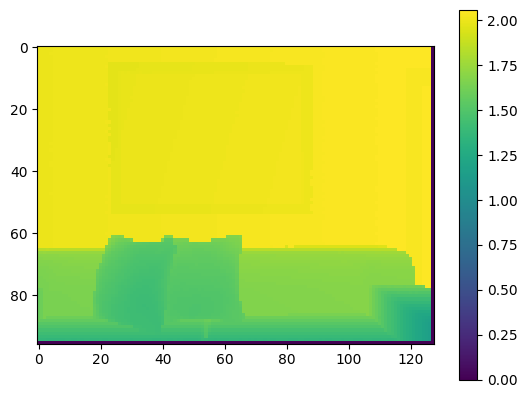

In [42]:
tr,q = jnp.zeros(3), jnp.array([1.0, 0.0, 0.0, 0.0])
print(b.translation_and_quaternion_to_pose_matrix(tr,q))
img = render_image_from_pose(tr,q)
print(img.shape)
b.get_depth_image(img)
import matplotlib.pyplot as plt
plt.imshow(img)
plt.colorbar()
img

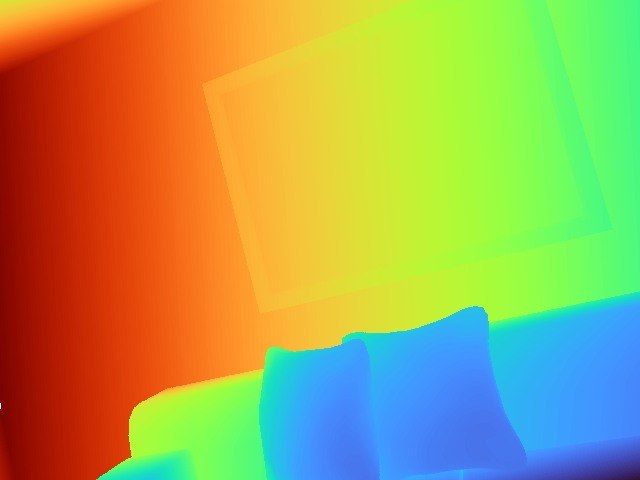

In [35]:
b.get_depth_image(original_depths[100])

In [32]:
b.clear()
cloud1 = b.unproject_depth_jit(original_depths[0], original_intrinsics)
b.show_cloud("1", b.apply_transform_jit(cloud1,poses[0]).reshape(-1,3))

T = 100
cloud2 = b.unproject_depth_jit(original_depths[T], original_intrinsics)
b.show_cloud("2", b.apply_transform_jit(cloud2, poses[T]).reshape(-1,3), color=b.RED)

NameError: name 'j' is not defined

In [ ]:
T1 = 140
point_cloud_image_1 = j.t3d.unproject_depth_jit(depths[T1], intrinsics)

T2 = 150
point_cloud_image_2 = j.t3d.unproject_depth_jit(depths[T2], intrinsics)

In [ ]:
j.hstack_images([
    j.get_rgb_image(rgbs[T1]),
    j.get_rgb_image(rgbs[T2]),
])

In [ ]:
j.hstack_images([
    j.get_depth_image(point_cloud_image_1[:,:,2]),
    j.get_depth_image(point_cloud_image_2[:,:,2]),
])

In [ ]:
mesh = j.mesh.make_voxel_mesh_from_point_cloud(point_cloud_image_1.reshape(-1,3), 0.05)

In [ ]:
renderer = j.Renderer(intrinsics)
renderer.add_mesh(mesh)

In [ ]:
j.meshcat.clear()

In [ ]:
j.meshcat.clear()
j.meshcat.show_trimesh("1",mesh)

In [ ]:
pose_estimate = jnp.eye(4)
NUM_SAMPLES_FOR_ESTIMATE=500
keys = jax.random.split(jax.random.PRNGKey(4), NUM_SAMPLES_FOR_ESTIMATE)
var,conc =  0.01, 1000.0
get_proposals = jax.jit(jax.vmap(lambda key,pose_estimate,var,conc: j.distributions.gaussian_vmf_sample(
    key, pose_estimate, var, conc),in_axes=(0,None,None,None)))
best_score = -jnp.inf

In [ ]:
for _ in tqdm(range(10)):
    for (var,conc) in [(0.01, 2000.0),(0.001, 2000.0),(0.1, 600.0)]:
        pose_proposals = get_proposals(keys, pose_estimate, var, conc)
        keys = jax.random.split(keys[0], NUM_SAMPLES_FOR_ESTIMATE)
        rendered_images = renderer.render_parallel(pose_proposals, 0)[...,:3]
        weights = j.threedp3_likelihood_parallel_jit(point_cloud_image_2, rendered_images, 0.0001, 0.1, 1.0)
        if weights.max() > best_score:
            best_score = weights.max()
            pose_estimate = pose_proposals[weights.argmax()]
        print(best_score)

    reconstruction = renderer.render_single_object(pose_estimate, 0)[:,:,:3]

j.meshcat.clear()
j.meshcat.show_cloud("1", point_cloud_image_2.reshape(-1,3))
j.meshcat.show_cloud("2", reconstruction.reshape(-1,3), color=j.RED)


In [ ]:
j.get_depth_image(renderer.render_single_object(pose_estimate, 0)[...,2])

In [ ]:
j.get_depth_image(point_cloud_image_2[:,:,2])

In [ ]:
point_cloud_1 = j.t3d.unproject_depth_jit(depths[T1], intrinsics)
point_cloud_2 = j.t3d.unproject_depth_jit(depths[T2], intrinsics)

correction_transform = j.t3d.inverse_pose(poses[T1]) @ poses[T2]
point_cloud_2_corrected = j.t3d.apply_transform_jit(j.t3d.unproject_depth_jit(depths[T2], intrinsics),  correction_transform)

In [ ]:
j.meshcat.clear()
j.meshcat.show_cloud("1", point_cloud_1.reshape(-1,3))
j.meshcat.show_cloud("2", point_cloud_2.reshape(-1,3), color=j.RED)

R = jnp.array([0.0001])
OUTLIER_PROB = 0.05
OUTLIER_VOLUME = 1.0
j.threedp3_likelihood_jit(point_cloud_1, point_cloud_2, jnp.zeros((point_cloud_2.shape[0], point_cloud_2.shape[1])), R,OUTLIER_PROB, OUTLIER_VOLUME)

In [ ]:
pc = point_cloud_1.reshape(-1,3)
noise = jax.vmap(
    lambda key: jax.random.multivariate_normal(
        key, jnp.zeros(3), jnp.eye(3) * R[0]
    )
)(
    jax.random.split(jax.random.PRNGKey(3), pc.shape[0])
)
pc_noisy = pc + noise
j.meshcat.clear()
j.meshcat.show_cloud("1", pc.reshape(-1,3))
j.meshcat.show_cloud("2", pc_noisy.reshape(-1,3), color=j.RED)

In [ ]:
j.meshcat.clear()
j.meshcat.show_cloud("1", point_cloud_1.reshape(-1,3))
j.meshcat.show_cloud("2", point_cloud_2_corrected.reshape(-1,3), color=j.RED)

j.meshcat.show_pose("pose", correction_transform)
j.threedp3_likelihood_jit(point_cloud_1, j.t3d.apply_transform(point_cloud_2, 
    correction_transform), jnp.zeros((point_cloud_2.shape[0], point_cloud_2.shape[1])), R,OUTLIER_PROB, OUTLIER_VOLUME)

In [ ]:
NUM_SAMPLES_FOR_ESTIMATE = 1000


In [ ]:
pose_estimate = jnp.eye(4)

In [ ]:
threedp3_likelihood_parallel_jit = jax.jit(jax.vmap(
    j.threedp3_likelihood,
    in_axes=(None, 0, None, None, None, None)
))


def refine_pose_estimate_inner(pose_estimate, point_cloud_1, point_cloud_2, keys, var, conc):
    keys = jax.random.split(keys[0], NUM_SAMPLES_FOR_ESTIMATE)
    pose_proposals = jax.vmap(lambda key: j.distributions.gaussian_vmf_sample(
        key, pose_estimate, var, conc))(
        keys
    )

    rendered_images = jnp.einsum(
        'aij,...j->a...i',
        pose_proposals,
        jnp.concatenate([point_cloud_2, jnp.ones(point_cloud_2.shape[:-1] + (1,))], axis=-1),
    )[..., :-1]

    best_score = j.threedp3_likelihood_jit(
        point_cloud_1, j.t3d.apply_transform(point_cloud_2, 
        pose_estimate), jnp.zeros((point_cloud_2.shape[0], point_cloud_2.shape[1])), R, OUTLIER_PROB, OUTLIER_VOLUME)
    
    weights = threedp3_likelihood_parallel_jit(
        point_cloud_1, rendered_images, jnp.zeros((point_cloud_2.shape[0], point_cloud_2.shape[1])), R,OUTLIER_PROB, OUTLIER_VOLUME)
    weights_max = weights.max()
    better = (weights_max > best_score)
    pose_estimate = pose_proposals[weights.argmax()] * better + pose_estimate* (1.0 - better)
    return pose_estimate, keys

refine_pose_estimate_jit = jax.jit(refine_pose_estimate_inner)

In [ ]:
for _ in tqdm(range(20)):
    pose_estimate,keys = refine_pose_estimate_jit(pose_estimate, point_cloud_1, point_cloud_2, keys, 0.01, 1000.0)
    pose_estimate,keys = refine_pose_estimate_jit(pose_estimate, point_cloud_1, point_cloud_2, keys, 0.005, 2000.0)
    pose_estimate,keys = refine_pose_estimate_jit(pose_estimate, point_cloud_1, point_cloud_2, keys, 0.001, 1000.0)
score = j.threedp3_likelihood_jit(
    point_cloud_1, j.t3d.apply_transform(point_cloud_2, 
    pose_estimate), jnp.zeros((point_cloud_2.shape[0], point_cloud_2.shape[1])), R, OUTLIER_PROB, OUTLIER_VOLUME)
keys[0],score

In [ ]:
j.meshcat.clear()
j.meshcat.show_cloud("1", point_cloud_1.reshape(-1,3))
j.meshcat.show_cloud("2", j.t3d.apply_transform(point_cloud_2, pose_estimate).reshape(-1,3), color=j.RED)

In [ ]:
j.meshcat.clear()
j.meshcat.show_cloud("1", point_cloud_1.reshape(-1,3))
j.meshcat.show_cloud("2", point_cloud_2.reshape(-1,3), color=j.RED)

In [ ]:
point_clouds = [
    unproject_depth(depths[t], intrinsics)
    for t in jnp.arange(200, 300, 5)
]
transforms = []
for i in tqdm(range(len(point_clouds) - 1)):
    pose_estimate = jnp.eye(4)
    point_cloud_1, point_cloud_2 = point_clouds[i], point_clouds[i+1]
    pose_estimate,keys = refine_pose_estimate_jit(pose_estimate, point_cloud_1, point_cloud_2, keys, 0.01, 1000.0)
    pose_estimate,keys = refine_pose_estimate_jit(pose_estimate, point_cloud_1, point_cloud_2, keys, 0.005, 2000.0)
    pose_estimate,keys = refine_pose_estimate_jit(pose_estimate, point_cloud_1, point_cloud_2, keys, 0.001, 1000.0)
    pose_estimate,keys = refine_pose_estimate_jit(pose_estimate, point_cloud_1, point_cloud_2, keys, 0.001, 1000.0)
    transforms.append(pose_estimate)


In [ ]:
i = 15

In [ ]:
j.meshcat.clear()
j.meshcat.show_cloud("1", point_clouds[i].reshape(-1,3))
j.meshcat.show_cloud("2", point_clouds[i+1].reshape(-1,3), color=j.RED)


In [ ]:
j.meshcat.clear()
j.meshcat.show_cloud("1", point_clouds[i].reshape(-1,3))
j.meshcat.show_cloud("2", j.t3d.apply_transform(point_clouds[i+1], transforms[i]).reshape(-1,3), color=j.RED)


In [ ]:
len(point_clouds)

In [ ]:
j.meshcat.clear()
j.meshcat.show_cloud("1", point_cloud_1.reshape(-1,3))


In [ ]:
j.meshcat.clear()
j.meshcat.show_cloud("2", j.t3d.apply_transform(point_cloud_2, pose_estimate).reshape(-1,3), color=j.RED)

In [ ]:
renderer = j.Renderer(intrinsics)
renderer.add_mesh(mesh)

In [ ]:
recontruction = renderer.render_single_object(j.t3d.inverse_pose(poses[T2]) @ poses[T1], 0)

In [ ]:
j.meshcat.clear()
j.meshcat.show_trimesh("!", mesh)

In [ ]:
j.meshcat.clear()
j.meshcat.show_cloud("1", point_cloud_1.reshape(-1,3))
j.meshcat.show_cloud("2", point_cloud_2.reshape(-1,3), color=j.RED)

In [ ]:
T_WIDTH = 0.01
translation_grid = j.make_translation_grid_enumeration(
    -T_WIDTH,-T_WIDTH,-T_WIDTH,
    T_WIDTH,T_WIDTH,T_WIDTH,
    11,11,11
)
rotation_grid = j.make_rotation_grid_enumeration(
    50, 40, -jnp.pi/40, jnp.pi/40, jnp.pi/40
)


pose_estimate = jnp.eye(4)
best_score = -1000000.0

In [ ]:
pose_proposals = jnp.einsum(
    'aij,jk->aik',
    translation_grid,
    pose_estimate,
    
)
rendered_images = jnp.einsum(
    'aij,...j->a...i',
    pose_proposals,
    jnp.concatenate([point_cloud_2, jnp.ones(point_cloud_2.shape[:-1] + (1,))], axis=-1),
)[..., :-1]

weights = j.threedp3_likelihood_parallel_jit(point_cloud_1, rendered_images, R, OUTLIER_PROB, OUTLIER_VOLUME)
weights_max = weights.max()
better = (weights_max > best_score)
pose_estimate = pose_proposals[weights.argmax()] * better + pose_estimate* (1.0 - better)
best_score = weights_max * better + best_score * (1.0 - better)
print(best_score)

pose_proposals = jnp.einsum(
    'ij,ajk->aik',
    pose_estimate,
    rotation_grid
)
rendered_images = jnp.einsum(
    'aij,...j->a...i',
    pose_proposals,
    jnp.concatenate([point_cloud_2, jnp.ones(point_cloud_2.shape[:-1] + (1,))], axis=-1),
)[..., :-1]


weights = j.threedp3_likelihood_parallel_jit(point_cloud_1, rendered_images, R, OUTLIER_PROB, OUTLIER_VOLUME)
weights_max = weights.max()
better = (weights_max > best_score)
pose_estimate = pose_proposals[weights.argmax()] * better + pose_estimate *(1.0 - better)
best_score = weights_max * better + best_score * (1.0 - better)
print(best_score)


In [ ]:
j.meshcat.clear()
for i in range(1000):
    j.meshcat.show_pose(f"{i}", poses[i], size=0.01)

In [ ]:
j.meshcat.clear()
j.meshcat.show_cloud("1", point_cloud_1.reshape(-1,3))


In [ ]:
j.meshcat.clear()
j.meshcat.show_cloud("1", point_cloud_1.reshape(-1,3))
j.meshcat.show_cloud("2", point_cloud_2.reshape(-1,3), color=j.RED)

In [ ]:
poses[1]

In [ ]:
poses[100]